 This is the same heart disease dataset from kaggle I used applying logistic regression. Here I will use the decision tree algorithm.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

In [46]:
# Reading the dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/heart.csv")
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [36]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [37]:
df["ca"].unique()

array([0, 2, 1, 3, 4])

In [47]:
# Great!The data doesn't have null values
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [39]:
len(df)

303

In [52]:
# Assigning data into X and Y
X = df.drop(["target"], axis=1)
y = df["target"]

In [41]:
X["cp"].unique()

array([3, 2, 1, 0])

In [50]:
# Getting dummies for categorical features
X_encoded = pd.get_dummies(X, columns=["cp",
                           "restecg",
                           "slope",
                           "thal"])
X_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


In [59]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

## Creating a decision tree and fitting it to the training data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)


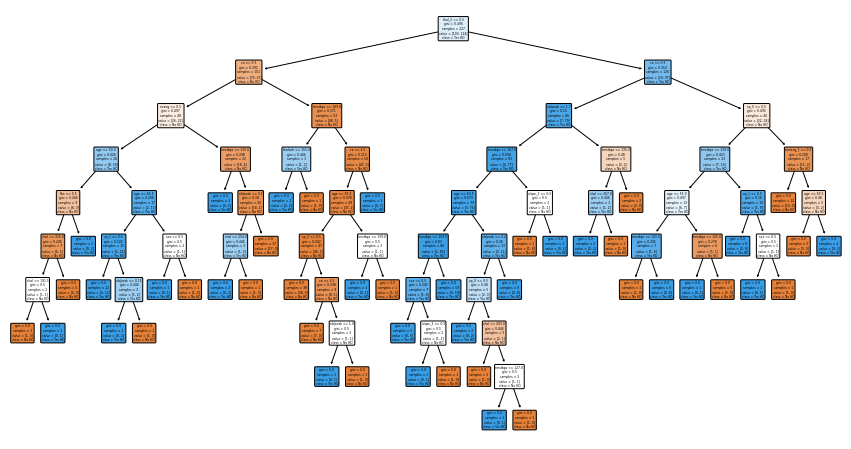

In [55]:
## Plotting the tree
plt.figure(figsize=(15, 8))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=X_encoded.columns);

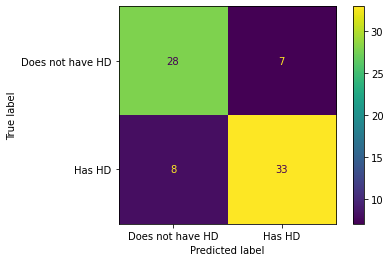

In [56]:
# Plotting a confusion a matrix
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["Does not have HD", "Has HD"]);

In [13]:
## Cost Complexity Pruning
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # Determine values for alpha
ccp_alphas = path.ccp_alphas # Extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # Exclude the maximum value for alpha

clf_dts = [] # Create an array that we will put decision trees into
# Now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

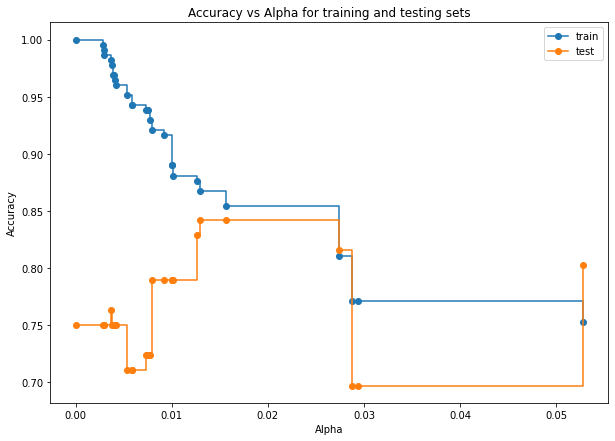

In [14]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts] 

fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show();

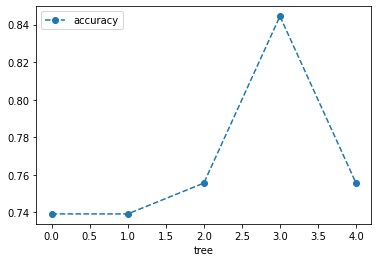

In [22]:
# Cross Validation for finding the best Alpha
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016) # Create the tree ccp_alpha=0.016

# Now use 5-fold cross validation creating 5 different training and testing datasets tha
#are the used to train and teste the tree
## Note: we use 5-fold because we don't have tons of data...
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={"tree": range(5), "accuracy": scores})

df.plot(x="tree", y="accuracy", marker="o", linestyle="--");

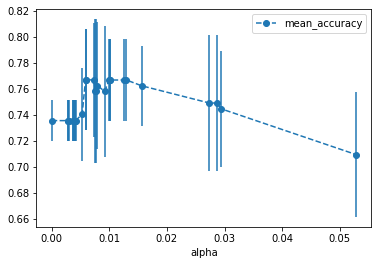

In [23]:
# Create an array to store the results of each fold during cross validation
alpha_loop_values = []

# For each candidate value for alpha, we will run 5-fold cross validation
# Then we will store the mean and standard deviation of the scores (the accuracy) for each call
#to croos_val_score in alpha_loop_values...
for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
  alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Now we can draw a graph of the means and standard deviations of the scores
#for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=["alpha", "mean_accuracy", "std"])

alpha_results.plot(x="alpha",
                   y="mean_accuracy",
                   yerr="std",
                   marker="o",
                   linestyle="--");

In [26]:
alpha_results[(alpha_results["alpha"] > 0.014)
              &
              (alpha_results["alpha"] < 0.016)]

,alpha,mean_accuracy,std
23,0.015628,0.762319,0.030839


In [27]:
ideal_ccp_alpha = alpha_results[(alpha_results["alpha"] > 0.014)
                                &
                                (alpha_results["alpha"] < 0.016)]["alpha"]


ideal_ccp_alpha

23    0.015628
Name: alpha, dtype: float64

In [28]:
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

0.015627803137520685

In [29]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

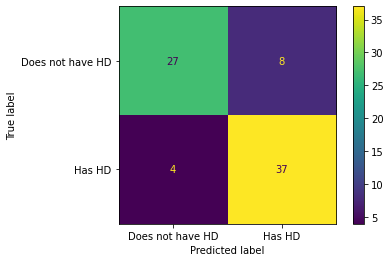

In [61]:
# That's the final confusion matrix after having applied the cost complexity pruning
# We can see clearly the increase of true positives and true negatives increasing the accuracy of 
#the model
plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=["Does not have HD", "Has HD"]);

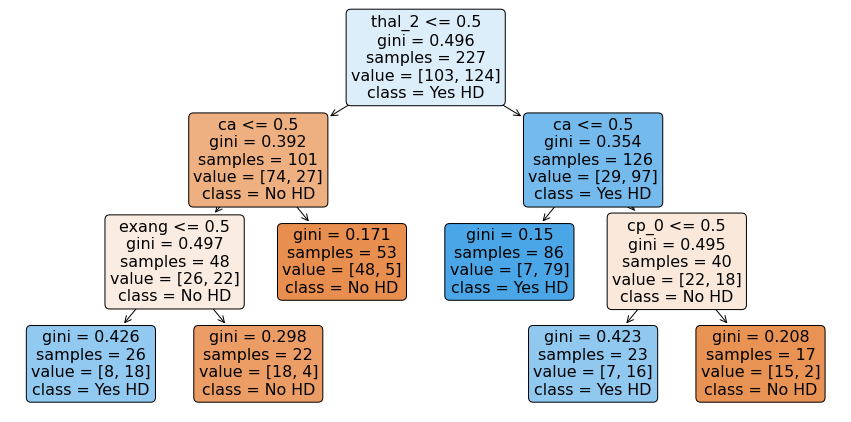

In [64]:
# And that's the final tree: a very small one than the initial tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=X_encoded.columns);